# INFO 2950 Project Phase 4

#### Talia Boehm, Lucy Barsanti, Emma Shen, Maddi Klancher


Link to dataset: https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp

In [66]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

import seaborn
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [4]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

# **Research Question:** 
* **Main Question**: How did the COVID-19 pandemic affect airline delays?

* **Supporting Questions**: What is the relationship between the COVID-19 rate and airline delays in the United States between January 2020 - July 2022? Does the relationship differ between states? By airline?

# **Data Cleaning:**

**Airline Delays Dataset**

* The data was exported as a CSV file. We did not remove any columns so that we could analyze all the different types of delays as well as geographic and carrier information. We basically did our “cleaning” by filtering on the BTS website to find flight delay information from January 2017 - July 2022.

**COVID-19 Cases Dataset**

* The data was exported as a CSV file. We removed unnecessary columns and added a couple of new columns to make our analysis easier. In addition, we compressed certain rows based on state, month, and year to ensure that our data were consistent with the airline delay dataset. The initial dataset was organized by day. A lot of these edits were made so as to ensure it was a fully usable dataset, and as well to ensure that there were no values that were null or would affect our analysis work. More specifically, our cleaning focused on:

* Converting objects to DateTime: This was a significant step, because much of our analysis required us to pull dates from the datasets. Unfortunately, the dates were not formatted within the CSV as DateTime objects, and thus our job was simply to transform these dates into DateTime objects. This was done using the pandas to_datetime() function, and assisted the team immensely in being able to directly pull the dates/times in a usable form for our data analysis. By being able to have these dates in DateTime objects, we are then able to use them without issue (in comparison to strings or other types) within our data analysis. 

* Adding month and year columns: In order to join the datasets by state, we needed to create new columns for the year and month of each record. This was simple since we already converted dates into DateTime objects. By adding these two columns, we were able to sum the covid cases and group by state, year, and month. 

* Removing all attributes except year	, month, state, tot_case, and new_case: We made the conscious decision to only use year, month, state, total cases, and new cases. We decided to omit the rest because our research question only pertains to COVID-19 cases, and not deaths. Moreover, we are not concerned with probable cases as the data is subjective based on whether or not consent was given to include those metrics. As a result, we decided to stick only with objective data for our analysis.

# Data Description

## Flight delay data from January 2017 - July 2022:

* This dataset contains information on flights in the United States from January 2017 to July 2022. The data contains attributes including the flight date, flight number, origin airport, destination airport, departure time, arrival time, and the reason for any delays. There are 7 reasons for flight delays outlined by the dataset: air carrier delay, weather delay, national aviation system delay, security delay, aircraft arriving late, canceled, and diverted. 

* Raw data can be found [here](https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp) 
* Link to our [Google Drive](https://drive.google.com/file/d/1Ci4XzBpg3BF-_zx70sBTN1uVkaERmTgl/view?usp=sharing)

* **Observations**: Each observation in the dataset includes the number of occurrences of each cause of delay for one airline at one airport for one month. For example, one row in the dataset represents the flight delay statistics for American Airlines at Nashville International Airport for the month of July 2022. 

* **Attributes**: The attributes of this dataset are as follows:

**year:** Year data collected\
**month:** Numeric representation of the month\
**carrier:** Airline carrier number\
**carrier_name:** Airline carrer\
**airport:** Official airport code\
**airport_name:** Full airport name\
**arr_flights:** Number of flights arriving at airport\
**arr_del15:** Number of flights more than 15 minutes late\
**carrier_ct:** Number of flights delayed due to air carrier. (e.g. no crew)\
**weather_ct:** Number of flights due to weather\
**nas_ct:** Number of flights delayed due to National Aviation System\
**security_ct:** Number of flights canceled due to a security breach\
**late_aircraft_ct:** Number of flights delayed as a result of another flight on the same aircraft delayed\
**arr_cancelled:** Total number of canceled flights\
**arr_diverted:** Total number of diverted flights\
**arr_delay:** Total number of minutes of delay for arriving flights\
**carrier_delay:** Total number of minutes of delay due to carrier delays\
**weather_delay:** Total number of minutes of delay due to weather delays\
**nas_delay:** Total number of minutes of delay due to National Aviation System delays\
**security_delay:** Total number of minutes of delay due to security delays\
**late_aircraft_delay:** Total time (minutes) of delay as a result of a previous flight on the same airplane being late

* The U.S. Department of Transportation (DOT) created and funded the monthly Air Travel Consumer Report to provide information to the public about the quality of air travel. In response, the Bureau of Transportation Statistics (BTS) began collecting details on the causes of flight delays in June 2003. The air travel data found on the BTS website is publicly available and required by the U.S. Congress.

* Operating carriers that have a 0.5 percent of total domestic scheduled-service passenger revenue are required to report on-time data and the causes of delay. Our data comes from these 17 operating carriers reporting non-stop scheduled-service flights between points within the United States and including territories. The DOT’s framework determined the reporting categories to ensure the public would have clear information about the nature and sources of airline delays and cancellations. The Bureau of Transportation Statistics conducted a pilot program to test the monthly reporting of causation and then implemented this framework in 2001.

* The DOT defines a “delayed” flight if it operated more than 15 minutes later than the scheduled arrival time. As a result, the data on delayed flights abides by this definition. 

* We downloaded the data from the BTS website as a CSV file.

## COVID-19 cases and deaths by state over time from January 22, 2020 - October 20, 2022:

* The raw data can be found [here](https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36/data)

* Link to our [Google Drive](https://drive.google.com/file/d/1i3fQ9wMkgdViOwuJO_EKLR2p1Hd_UCyF/view?usp=sharing)

* This dataset contains archived aggregate daily counts of COVID-19 cases and death by state. 

* **Observations**: Each observation contains archived aggregate daily counts of COVID-19 cases and death for each state in the United States. For example, we can see one row that contains data from 10/18/22 for the state of New York with 3,275,131 total cases, 1,660 new cases, 29,356 total deaths, 32 new deaths, and 0 new probable deaths.

* **Attributes**: The attributes of this dataset are as follows:

**submission_date:** date of counts\
**state:** jurisdiction\
**tot_cases:** total number of cases\
**conf_cases:** total confirmed cases\
**prob_cases:** total probable cases\
**new_case:** number of new cases\
**pnew_case:** number of new probable cases\
**tot_death:** total number of deaths\
**conf_death:** total confirmed deaths\
**prob_death:** total probable deaths\
**new_death:** number of new deaths\
**pnew_death:** number of new probable deaths\
**created_at:** date and time record was created\
**consent_cases:** if agree, then confirmed and probable cases are included\
**consent_deaths:** if agree, then confirmed and probable deaths are included\
**year:** year or counts\
**month:** month of counts


* The Centers for Disease Control and Prevention (CDC) made the United States COVID-19 Cases and Deaths by State over Time dataset to track the spread of COVID-19 in the United States. The United States government funded this dataset. 

* We are using the data to compare flight delay information with COVID-19 cases on a monthly basis based on state to determine if there is any relationship between the two datasets.

* The CDC retrieves aggregate case and death data from jurisdictional and state partners. However, counting the exact number of COVID-19 cases is not possible due to a variety of reasons. For instance, people do not always report their illnesses, symptoms might not appear immediately, and there may be delays in testing. Moreover, there are sometimes false test results. Additionally, each state may have different testing and reporting protocols, population sentiment toward COVID-19, and levels of testing efficiency.

* We downloaded the data from the CDC’s website as a CSV file.

# Data Limitation

#### **First Data Set (Flight Delays)**:

* The data is somewhat limited because it does not include all flight data for the specified time period. Although the US has ​​19,622 airports, the data only includes information about 384 airports. Another limitation is that the data does not cover delays experienced by flights operated by US-based airlines but originating or arriving at airports outside the US. Although we are looking at the relationship between COVID-19 cases and delays in the US, international statistics could potentially affect our data too.

#### **Second Data Set (COVID-19 Cases)**:

* There are several limitations to any COVID-19 dataset. First, there is a lot of noise and misinformation surrounding the pandemic, making it difficult to separate fact from fiction. Secondly, different jurisdictions handle their data differently, making it difficult to get a complete picture of the pandemic within the United States. The data may also be affected by political and geographical demographics.

# Exploratory Data Analysis 

## 1. Flight Delays Dataset
_Note: For a detailed description of this dataset, please see the section "Data Description" above._

The following cells show a preview of the original Flight Delay dataframe.
•	This dataframe is stored in the variable df_delays


In [6]:
df_delays = pd.read_csv('Airline_Delay_Cause.csv')
df_delays.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.0,0.00,0.0,0.0,129.0,98.0,23.0,8.0,0.0,0.0
1,2022,7,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",78.0,25.0,11.80,0.72,...,0.0,7.48,0.0,0.0,1664.0,887.0,52.0,224.0,0.0,501.0
2,2022,7,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",124.0,19.0,5.84,1.00,...,0.0,5.40,5.0,4.0,1523.0,388.0,35.0,511.0,0.0,589.0
3,2022,7,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",67.0,10.0,1.32,1.00,...,1.0,4.28,0.0,1.0,657.0,103.0,82.0,93.0,25.0,354.0
4,2022,7,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",174.0,30.0,18.10,5.75,...,0.0,2.55,1.0,0.0,2462.0,1686.0,310.0,139.0,0.0,327.0


### Inserting new column "state"
By parsing each value in the column __airport_name__, we extracted the 2-character state abbrevaition for each row of data and created a new column __state__.

_Rationale for change:_ As you will see in the next section, the COVID dataset has a column- state- containing the state pertinent to each row of data. To combine the COVID and Flight Delay for specific stats, we needed to insert the column state into df_delays. This addition allows us to join the 2 datasets on the __state__ column.

In the preview of df_delays below, you can see the new column titled __state__


In [7]:
airports= df_delays['airport_name']
state = []
for x in airports:
    idx = x.rindex(":")
    start = idx - 2
    state_x = x[start: idx]
    state.append(state_x)

df_delays['state'] = state
df_delays.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.00,0.0,0.0,129.0,98.0,23.0,8.0,0.0,0.0,PA
1,2022,7,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",78.0,25.0,11.80,0.72,...,7.48,0.0,0.0,1664.0,887.0,52.0,224.0,0.0,501.0,GA
2,2022,7,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",124.0,19.0,5.84,1.00,...,5.40,5.0,4.0,1523.0,388.0,35.0,511.0,0.0,589.0,MA
3,2022,7,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",67.0,10.0,1.32,1.00,...,4.28,0.0,1.0,657.0,103.0,82.0,93.0,25.0,354.0,LA
4,2022,7,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",174.0,30.0,18.10,5.75,...,2.55,1.0,0.0,2462.0,1686.0,310.0,139.0,0.0,327.0,GA


## 2. COVID Data by State

_Note: For a detailed description of this dataset, please see the section "Data Description" above._

The following cells show a preview of the dataframe stored in the variable __df_covid__. The dataset contains information about COVID cases over time in each US State.

In [8]:
df_covid = pd.read_csv('Covid-by-State.csv')
df_covid['submission_date']= pd.to_datetime(df_covid['submission_date'])
df_covid['year'] = pd.DatetimeIndex(df_covid['submission_date']).year
df_covid['month'] = pd.DatetimeIndex(df_covid['submission_date']).month
df_covid.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths,year,month
0,2021-03-11,KS,297229,241035.0,56194.0,0,0.0,4851,NaN,NaN,0,0.0,03/12/2021 03:20:13 PM,Agree,NaN,2021,3
1,2021-12-01,ND,163565,135705.0,27860.0,589,220.0,1907,NaN,NaN,9,0.0,12/02/2021 02:35:20 PM,Agree,Not agree,2021,12
2,2022-01-02,AS,11,NaN,NaN,0,0.0,0,NaN,NaN,0,0.0,01/03/2022 03:18:16 PM,NaN,NaN,2022,1
3,2021-11-22,AL,841461,620483.0,220978.0,703,357.0,16377,12727.0,3650.0,7,3.0,11/22/2021 12:00:00 AM,Agree,Agree,2021,11
4,2022-05-30,AK,251425,NaN,NaN,0,0.0,1252,NaN,NaN,0,0.0,05/31/2022 01:20:20 PM,NaN,NaN,2022,5


### Cleaning the COVID Dataset

Steps taken to clean __df_covid__:
- Summing COVID data for each MONTH
- Grouping and ordering by: state, month, and year
    - The flight delay dataset and the COVID dataset have these 3 columns in common, so this is how we will group and order our data when combining __df_covid__ and __df_delays__
    - This ordering is also logical because the year/ month increases as you travel down the rows in the dataset, and the states are ordered alphabetically (A-Z)


In [9]:

%sql df_covid_cleaned << SELECT year, month, state, SUM(tot_cases) AS tot_case, SUM(new_case) AS new_case FROM df_covid GROUP BY state, month, year ORDER BY year, month, state ASC

df_covid_cleaned


Returning data to local variable df_covid_cleaned


,year,month,state,tot_case,new_case
0,2020,1,AK,0,0
1,2020,1,AL,0,0
2,2020,1,AR,0,0
3,2020,1,AS,0,0
4,2020,1,AZ,6,1
...,...,...,...,...,...
2035,2022,10,VT,2394457,1530
2036,2022,10,WA,32827982,12770
2037,2022,10,WI,33758028,17572
2038,2022,10,WV,10850608,4454


In [10]:
## Lucy
dates = df_covid_cleaned[['year', 'month']]
month_date = []

for x in dates.index:
    if dates['month'][x] <= 9:
        month_date_x = (dates['year'][x]) + (dates['month'][x] / 12)
    else:
        month_date_x = (dates['year'][x]) + (dates['month'][x] / 12)
    
    month_date.append(float(month_date_x))
    
df_covid_cleaned['year_month'] = month_date

df_covid_cleaned.head()


,year,month,state,tot_case,new_case,year_month
0,2020,1,AK,0,0,2020.083333
1,2020,1,AL,0,0,2020.083333
2,2020,1,AR,0,0,2020.083333
3,2020,1,AS,0,0,2020.083333
4,2020,1,AZ,6,1,2020.083333


## Visualization 1: New COVID Cases by State

This visualaization uses a Log Scale to show how COVID cases increased in each state over time. 

### Insights

- COVID cases skyrocketed at the beginning months of 2020
- COVID cases have remained high from 5/2020 to 7/2022 despite fluctuations.
- Trend lines for each state are parallel to one another, suggesting that the rate of new infections has changed at similar rates across state lines. 

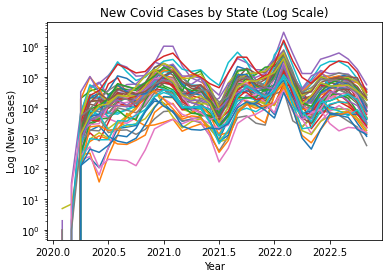

In [11]:
## Lucy
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

plt.yscale('log')
plt.title("New Covid Cases by State (Log Scale)")
plt.xlabel("Year")
plt.ylabel("Log (New Cases)")

for state in states:
    state_data_find = pd.Series(df_covid_cleaned['state'] == state)
    
    state_data = df_covid_cleaned.loc[state_data_find]
    x = state_data['year_month']
    y = state_data['new_case']
    
    plt.plot(x, y)

##print(ak_data)

In [13]:
## MADDI
%sql Endeavor_ABE_22_df << SELECT * FROM df_delays WHERE carrier = '9E' AND airport = 'ABE' AND year = 2022
Endeavor_ABE_22_df.head()

Returning data to local variable Endeavor_ABE_22_df


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.00,0.0,0.0,129.0,98.0,23.0,8.0,0.0,0.0,PA
1,2022,6,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",133.0,14.0,9.28,0.03,...,3.04,3.0,0.0,853.0,625.0,2.0,56.0,0.0,170.0,PA
2,2022,5,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",136.0,7.0,5.95,0.00,...,1.00,0.0,0.0,255.0,222.0,0.0,4.0,0.0,29.0,PA
3,2022,4,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",132.0,6.0,2.00,0.00,...,0.18,0.0,0.0,170.0,58.0,0.0,101.0,0.0,11.0,PA
4,2022,3,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",135.0,12.0,4.21,1.93,...,1.78,0.0,1.0,513.0,124.0,180.0,107.0,25.0,77.0,PA


## Visualization 2: Endeavor Air Inc. Delays at ABE from Jan-Jul 2022

This is a lineplot showing the number of Endeavor Airlines flight delays at airport ABE (Allentown/Bethlehem/ Easton) over time.

Since we are not familiar with airline delay data, we wanted to see how delays change over a short period of time. 


### Insights:
- There is major fluctuation in delays over a period this short for the given airline and airport
    - The number of delays is fairly low for this airport
- The number of delayed flights may not be an effective metric given the differences in sizes across airports. We will likely use the percentage of total fights delayed when comparing/analyzing data from more than one airport.

[Text(0.5, 1.0, 'Endeavor Air Inc. Delays at ABE from Jan-Jul 2022')]

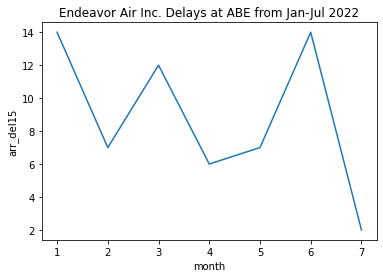

In [14]:
## MADDI
seaborn.lineplot(data=Endeavor_ABE_22_df, x="month", y="arr_del15").set(title='Endeavor Air Inc. Delays at ABE from Jan-Jul 2022')

## Visualization 3: Delta Airline Delays at LAX by month

To better understand flight delay trends from 2020-2022, we plotted the total # of delays on Delta Airlines at the Los Angeles Airport (LAX) over the past 2 years. 

In [15]:
## MADDI
%sql Delta_LAX_Jan_df << SELECT * FROM df_delays WHERE carrier = 'DL' AND airport = 'LAX'
Delta_LAX_Jan_df.head()

dates = Delta_LAX_Jan_df[['year', 'month']]
month_date = []

for x in dates.index:
    if dates['month'][x] <= 9:
        month_date_x = (dates['year'][x]) + (dates['month'][x] / 12)
    else:
        month_date_x = (dates['year'][x]) + (dates['month'][x] / 12)
    
    month_date.append(float(month_date_x))
    
Delta_LAX_Jan_df['year_month'] = month_date

Delta_LAX_Jan_df.head()

Returning data to local variable Delta_LAX_Jan_df


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state,year_month
0,2022,7,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2934.0,488.0,221.01,12.42,...,26.0,1.0,38128.0,20967.0,842.0,3984.0,0.0,12335.0,CA,2022.583333
1,2022,6,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2855.0,604.0,302.15,16.86,...,104.0,3.0,39156.0,22502.0,1213.0,5618.0,55.0,9768.0,CA,2022.500000
2,2022,5,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2582.0,462.0,214.30,11.48,...,79.0,0.0,29272.0,15948.0,1044.0,5573.0,0.0,6707.0,CA,2022.416667
3,2022,4,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2394.0,477.0,193.98,8.25,...,14.0,0.0,30748.0,15994.0,1142.0,6193.0,51.0,7368.0,CA,2022.333333
4,2022,3,DL,Delta Air Lines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2440.0,432.0,162.50,13.55,...,12.0,2.0,28342.0,12323.0,1432.0,6798.0,0.0,7789.0,CA,2022.250000


### Insights 

- Shown in the graph below, there seems to be a general increase in the number of delayed flights over time. 

- In both the previous graph of Endeavor Airlines, and in the graph below, it's important to note that despite an overall increase in delays, there is significant fluctuation in delays month-month. 
- Delta at LAX has a lot more delays than Endeavor Air at ABE
    - This reinforces that we should use percent of total flights delayed instead of counts due to variation between airports


(array([2016., 2017., 2018., 2019., 2020., 2021., 2022., 2023.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

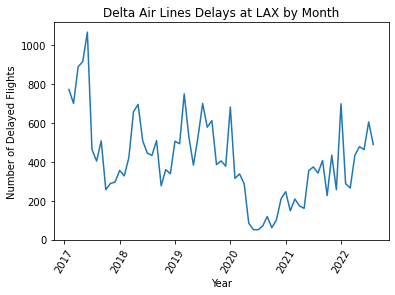

In [16]:
## MADDI
seaborn.lineplot(data=Delta_LAX_Jan_df, x="year_month", y="arr_del15").set(title='Delta Air Lines Delays at LAX by Month')
plt.xlabel('Year')
plt.ylabel('Number of Delayed Flights')
plt.xticks(rotation=60)

In [17]:
## MADDI
%sql JFK_Jul_2022_df << SELECT * FROM df_delays WHERE airport = 'JFK' AND year = 2022 AND month = 7
JFK_Jul_2022_df.head()

Returning data to local variable JFK_Jul_2022_df


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state
0,2022,7,9E,Endeavor Air Inc.,JFK,"New York, NY: John F. Kennedy International",2056.0,339.0,101.78,9.83,...,96.30,164.0,8.0,31737.0,11239.0,672.0,10642.0,0.0,9184.0,NY
1,2022,7,AA,American Airlines Inc.,JFK,"New York, NY: John F. Kennedy International",1385.0,366.0,124.81,14.06,...,109.62,51.0,5.0,25924.0,10864.0,1151.0,5783.0,37.0,8089.0,NY
2,2022,7,AS,Alaska Airlines Inc.,JFK,"New York, NY: John F. Kennedy International",372.0,58.0,17.69,0.00,...,12.86,0.0,2.0,2399.0,705.0,0.0,1011.0,13.0,670.0,NY
3,2022,7,B6,JetBlue Airways,JFK,"New York, NY: John F. Kennedy International",4064.0,1349.0,442.29,31.36,...,525.91,96.0,15.0,114603.0,40584.0,3240.0,20408.0,184.0,50187.0,NY
4,2022,7,DL,Delta Air Lines Inc.,JFK,"New York, NY: John F. Kennedy International",2318.0,515.0,172.85,10.08,...,122.60,50.0,10.0,41027.0,21033.0,621.0,8859.0,76.0,10438.0,NY


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Endeavor Air Inc.'),
  Text(1, 0, 'American Airlines Inc.'),
  Text(2, 0, 'Alaska Airlines Inc.'),
  Text(3, 0, 'JetBlue Airways'),
  Text(4, 0, 'Delta Air Lines Inc.'),
  Text(5, 0, 'Hawaiian Airlines Inc.'),
  Text(6, 0, 'United Air Lines Inc.'),
  Text(7, 0, 'Republic Airline')])

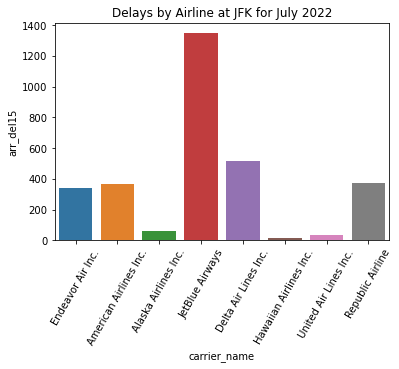

In [18]:
seaborn.barplot(data=JFK_Jul_2022_df, x="carrier_name", y="arr_del15").set(title='Delays by Airline at JFK for July 2022')
plt.xticks(rotation=60)

In [19]:
df_delays.describe()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,101315.000000,101315.000000,101157.000000,100960.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000,101157.000000
mean,2019.516261,6.279633,336.033413,58.073217,18.457503,2.047227,17.234516,0.153487,20.067422,7.969137,0.773362,3817.083069,1319.266744,212.609785,838.294967,7.370395,1439.534031
std,1.558253,3.438409,942.283273,163.327000,47.042014,6.878678,58.427910,0.734138,63.043181,50.943481,3.395803,11715.243158,3941.461650,810.274436,3390.448796,44.296998,4636.488256
min,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,3.000000,42.000000,5.000000,1.920000,0.000000,0.940000,0.000000,1.000000,0.000000,0.000000,265.000000,86.000000,0.000000,24.000000,0.000000,42.000000
50%,2020.000000,6.000000,90.000000,14.000000,5.280000,0.240000,3.200000,0.000000,3.960000,1.000000,0.000000,865.000000,316.000000,12.000000,120.000000,0.000000,253.000000
75%,2021.000000,9.000000,227.000000,40.000000,14.610000,1.660000,9.850000,0.000000,12.640000,4.000000,1.000000,2520.000000,990.000000,132.000000,401.000000,0.000000,916.000000
max,2022.000000,12.000000,21931.000000,4176.000000,1147.000000,226.000000,1884.420000,58.690000,1531.810000,4951.000000,154.000000,429194.000000,151581.000000,28294.000000,112018.000000,3760.000000,147167.000000


In [20]:
df_delays.corr()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
year,1.000000,-0.155467,-0.045741,-0.052033,0.003139,-0.006195,-0.078704,0.041144,-0.064294,0.020882,-0.029242,-0.042815,0.000369,-0.005601,-0.073744,0.024950,-0.053831
month,-0.155467,1.000000,0.003289,0.000730,0.004245,-0.013358,-0.003259,0.015770,0.004057,-0.062263,-0.002099,-0.003220,-0.001703,-0.017581,-0.006071,0.011451,0.000713
arr_flights,-0.045741,0.003289,1.000000,0.912000,0.888108,0.721935,0.807840,0.452680,0.865338,0.394412,0.642095,0.873406,0.873891,0.650337,0.691119,0.370965,0.841404
arr_del15,-0.052033,0.000730,0.912000,1.000000,0.933790,0.758786,0.908542,0.480457,0.961273,0.334992,0.699186,0.968492,0.901808,0.688448,0.825927,0.387705,0.952495
carrier_ct,0.003139,0.004245,0.888108,0.933790,1.000000,0.740153,0.740210,0.504726,0.898324,0.326015,0.640724,0.895239,0.938776,0.657059,0.642906,0.412139,0.875101
weather_ct,-0.006195,-0.013358,0.721935,0.758786,0.740153,1.000000,0.662026,0.340264,0.685323,0.260448,0.631279,0.797202,0.789265,0.923342,0.622884,0.291255,0.723744
nas_ct,-0.078704,-0.003259,0.807840,0.908542,0.740210,0.662026,1.000000,0.379469,0.796030,0.299565,0.655763,0.893506,0.749021,0.615367,0.944719,0.306694,0.819624
security_ct,0.041144,0.015770,0.452680,0.480457,0.504726,0.340264,0.379469,1.000000,0.466757,0.164975,0.315337,0.431427,0.440735,0.285949,0.302236,0.804406,0.436771
late_aircraft_ct,-0.064294,0.004057,0.865338,0.961273,0.898324,0.685323,0.796030,0.466757,1.000000,0.315598,0.651481,0.918850,0.848459,0.617503,0.711206,0.370807,0.968901
arr_cancelled,0.020882,-0.062263,0.394412,0.334992,0.326015,0.260448,0.299565,0.164975,0.315598,1.000000,0.278944,0.342342,0.338653,0.263105,0.285270,0.126739,0.321329


In [21]:
df_delays.cov()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
year,2.428154,-0.832977,-6.718626e+01,-1.325660e+01,0.230191,-0.066425,-7.168262,0.047085,-6.318323,1.658279,-0.154792,-7.818894e+02,2.268752e+00,-7.075067e+00,-3.897434e+02,1.722785,-3.890604e+02
month,-0.832977,11.822658,1.065531e+01,4.102916e-01,0.686685,-0.315940,-0.654819,0.039809,0.879325,-10.906314,-0.024509,-1.297061e+02,-2.307489e+01,-4.898322e+01,-7.077646e+01,1.744172,1.137298e+01
arr_flights,-67.186256,10.655307,8.878978e+05,1.404775e+05,39367.088162,4679.338144,44476.155668,313.148556,51405.029711,18933.043955,2054.580549,9.641598e+06,3.245608e+06,4.965375e+05,2.207962e+06,15484.212247,3.675999e+06
arr_del15,-13.256602,0.410292,1.404775e+05,2.667571e+04,7180.440447,853.234061,8677.801335,57.662711,9906.566675,2789.656871,388.144232,1.854742e+06,5.810391e+05,9.119166e+04,4.577775e+05,2807.667120,7.219255e+05
carrier_ct,0.230191,0.686685,3.936709e+04,7.180440e+03,2212.951086,239.503881,2034.515759,17.430875,2664.141276,781.290124,102.352660,4.933739e+05,1.740625e+05,2.504507e+04,1.025393e+05,858.822499,1.908681e+05
weather_ct,-0.066425,-0.315940,4.679338e+03,8.532341e+02,239.503881,47.316213,266.072638,1.718300,297.192779,91.267118,14.745818,6.424280e+04,2.139860e+04,5.146355e+03,1.452679e+04,88.746870,2.308229e+04
nas_ct,-7.168262,-0.654819,4.447616e+04,8.677801e+03,2034.515759,266.072638,3413.820663,16.276992,2932.163117,891.661189,130.109759,6.116023e+05,1.724931e+05,2.913312e+04,1.871459e+05,793.778819,2.220363e+05
security_ct,0.047085,0.039809,3.131486e+02,5.766271e+01,17.430875,1.718300,16.276992,0.538958,21.602632,6.169991,0.786131,3.710536e+03,1.275302e+03,1.700977e+02,7.522819e+02,26.159352,1.486691e+03
late_aircraft_ct,-6.318323,0.879325,5.140503e+04,9.906567e+03,2664.141276,297.192779,2932.163117,21.602632,3974.442679,1013.585544,139.470473,6.786315e+05,2.108271e+05,3.154346e+04,1.520165e+05,1035.524721,2.832089e+05
arr_cancelled,1.658279,-10.906314,1.893304e+04,2.789657e+03,781.290124,91.267118,891.661189,6.169991,1013.585544,2595.238262,48.255570,2.043152e+05,6.799876e+04,1.086049e+04,4.927227e+04,286.004521,7.589764e+04


In [22]:
## MADDI

%sql year20_df << SELECT * FROM df_delays WHERE year = 2020
year20_df.head()

Returning data to local variable year20_df


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state
0,2020,12,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",44.0,3.0,1.63,0.0,...,1.25,0.0,1.0,89.0,56.0,0.0,3.0,0.0,30.0,PA
1,2020,12,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",90.0,1.0,0.96,0.0,...,0.00,0.0,0.0,23.0,22.0,0.0,1.0,0.0,0.0,GA
2,2020,12,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",88.0,8.0,5.75,0.0,...,0.65,0.0,1.0,338.0,265.0,0.0,45.0,0.0,28.0,LA
3,2020,12,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",184.0,9.0,4.17,0.0,...,3.00,0.0,0.0,508.0,192.0,0.0,92.0,0.0,224.0,GA
4,2020,12,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",76.0,11.0,4.78,0.0,...,1.00,1.0,0.0,692.0,398.0,0.0,178.0,0.0,116.0,NY


Text(0.5, 1.0, 'Number of Delays in 2020')

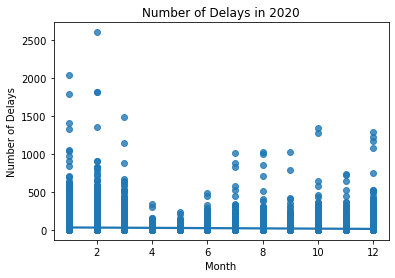

In [23]:
# scatterplot for x1 and y1
seaborn.regplot(data = year20_df, x='month', y='arr_del15')
plt.xlabel("Month")
plt.ylabel("Number of Delays")
plt.title("Number of Delays in 2020")

In [24]:
df_delays["percent_delayed"] = df_delays["arr_del15"]/df_delays["arr_flights"]
df_delays["percent_cancelled"] = df_delays["arr_cancelled"]/df_delays["arr_flights"]
df_delays.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,state,percent_delayed,percent_cancelled
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,0.0,129.0,98.0,23.0,8.0,0.0,0.0,PA,0.060606,0.000000
1,2022,7,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",78.0,25.0,11.80,0.72,...,0.0,1664.0,887.0,52.0,224.0,0.0,501.0,GA,0.320513,0.000000
2,2022,7,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",124.0,19.0,5.84,1.00,...,4.0,1523.0,388.0,35.0,511.0,0.0,589.0,MA,0.153226,0.040323
3,2022,7,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",67.0,10.0,1.32,1.00,...,1.0,657.0,103.0,82.0,93.0,25.0,354.0,LA,0.149254,0.000000
4,2022,7,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",174.0,30.0,18.10,5.75,...,0.0,2462.0,1686.0,310.0,139.0,0.0,327.0,GA,0.172414,0.005747


In [26]:
## LUCY
%sql df_covid_flight << SELECT df_delays.*, df_covid_cleaned.tot_case, df_covid_cleaned.new_case, df_covid_cleaned.year_month FROM df_delays INNER JOIN df_covid_cleaned ON df_delays.month = df_covid_cleaned.month AND df_delays.year = df_covid_cleaned.year AND df_delays.State = df_covid_cleaned.state

df_covid_flight

Returning data to local variable df_covid_flight


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,state,percent_delayed,percent_cancelled,tot_case,new_case,year_month
0,2022,7,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",33.0,2.0,0.92,1.00,...,23.0,8.0,0.0,0.0,PA,0.060606,0.000000,94451196,83892,2022.583333
1,2022,7,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",78.0,25.0,11.80,0.72,...,52.0,224.0,0.0,501.0,GA,0.320513,0.000000,83574171,103347,2022.583333
2,2022,7,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",124.0,19.0,5.84,1.00,...,35.0,511.0,0.0,589.0,MA,0.153226,0.040323,60291430,42217,2022.583333
3,2022,7,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",67.0,10.0,1.32,1.00,...,82.0,93.0,25.0,354.0,LA,0.149254,0.000000,39327318,54312,2022.583333
4,2022,7,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",174.0,30.0,18.10,5.75,...,310.0,139.0,0.0,327.0,GA,0.172414,0.005747,83574171,103347,2022.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50634,2020,1,YV,Mesa Airlines Inc.,RIC,"Richmond, VA: Richmond International",5.0,1.0,1.00,0.00,...,0.0,0.0,0.0,0.0,VA,0.200000,0.000000,0,0,2020.083333
50635,2020,1,YV,Mesa Airlines Inc.,ROA,"Roanoke, VA: Roanoke Blacksburg Regional Woodr...",1.0,1.0,0.00,0.00,...,0.0,0.0,0.0,61.0,VA,1.000000,0.000000,0,0,2020.083333
50636,2020,1,YX,Republic Airline,BTV,"Burlington, VT: Burlington International",173.0,22.0,4.36,0.00,...,0.0,207.0,0.0,520.0,VT,0.127168,0.005780,0,0,2020.083333
50637,2020,1,YX,Republic Airline,ORF,"Norfolk, VA: Norfolk International",93.0,13.0,3.68,0.00,...,0.0,79.0,0.0,337.0,VA,0.139785,0.010753,0,0,2020.083333


In [27]:
ny_data_find = pd.Series(df_covid_flight['state'] == 'NY')
    
ny_data = df_covid_flight.loc[ny_data_find]

ny_data.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,state,percent_delayed,percent_cancelled,tot_case,new_case,year_month
5,2022,7,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",114.0,16.0,3.70,1.82,...,207.0,64.0,0.0,743.0,NY,0.140351,0.043860,94401130,86951,2022.583333
11,2022,7,9E,Endeavor Air Inc.,BGM,"Binghamton, NY: Greater Binghamton/Edwin A. Li...",31.0,6.0,2.47,0.00,...,0.0,51.0,0.0,18.0,NY,0.193548,0.000000,94401130,86951,2022.583333
19,2022,7,9E,Endeavor Air Inc.,BUF,"Buffalo, NY: Buffalo Niagara International",177.0,24.0,8.62,1.40,...,105.0,345.0,0.0,225.0,NY,0.135593,0.079096,94401130,86951,2022.583333
49,2022,7,9E,Endeavor Air Inc.,HPN,"White Plains, NY: Westchester County",50.0,8.0,4.18,0.90,...,206.0,96.0,0.0,16.0,NY,0.160000,0.020000,94401130,86951,2022.583333
53,2022,7,9E,Endeavor Air Inc.,ITH,"Ithaca/Cortland, NY: Ithaca Tompkins Regional",10.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,NY,0.000000,0.000000,94401130,86951,2022.583333


In [28]:
%sql df_ny_covid_flight << SELECT SUM(new_case) as new_cases, SUM(arr_del15) as delayed_flights FROM ny_data GROUP BY year_month

df_ny_covid_flight.head()

Returning data to local variable df_ny_covid_flight


,new_cases,delayed_flights
0,7043031,8040.0
1,6040185,8257.0
2,13318096,8108.0
3,9554864,7709.0
4,3493922,7839.0


## Visualization 7

This visualization of Delayed Flights vs. New COVID Cases for New York shows us that there is not a strong relationship between the number of delaydfed flights and the number of new covid cases at first glance. We will have to do some further data exploration to try to understand why.

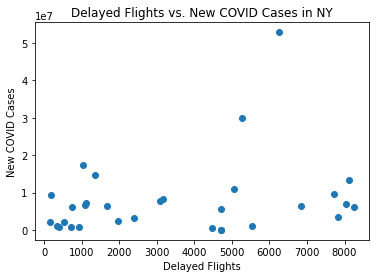

In [29]:
ny_x = df_ny_covid_flight['delayed_flights']
ny_y = df_ny_covid_flight['new_cases']

plt.scatter(ny_x, ny_y)
plt.xlabel("Delayed Flights")
plt.ylabel("New COVID Cases")
plt.title("Delayed Flights vs. New COVID Cases in NY")
plt.show()

## Visualizations for carrier_ct vs new covid cases

This visualization of carrier_ct for a random sample of airlines shows us the time series of delays caused by the air carrier (ie. no crew). This will help us to understand if there is a relationship between covid cases and air carrier delays. 

<AxesSubplot:xlabel='year_month', ylabel='carrier_ct'>

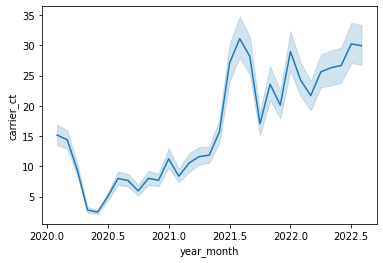

In [30]:
seaborn.lineplot(data=df_covid_flight, x='year_month', y='carrier_ct')

<AxesSubplot:xlabel='year_month', ylabel='new_case'>

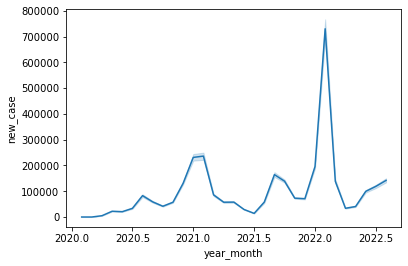

In [31]:
seaborn.lineplot(data=df_covid_flight, x='year_month', y='new_case')

In [32]:
carrier_ct_df = df_covid_flight['carrier_ct']
new_cases_df = df_covid_flight['new_case']

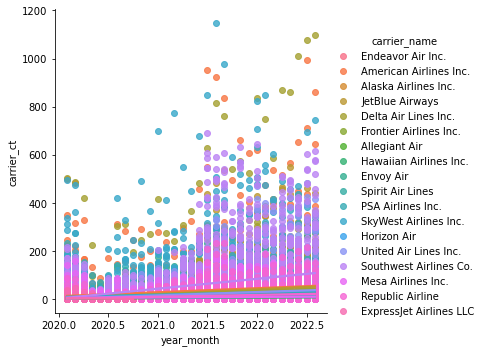

In [33]:
seaborn.lmplot(x='year_month', y='carrier_ct', data=df_covid_flight, hue = 'carrier_name')

In [54]:
%sql df_carrier_delay << SELECT state, year_month, sum(carrier_ct) AS carrier_ct FROM df_covid_flight GROUP BY state, year_month ORDER BY state ASC

Returning data to local variable df_carrier_delay


In [52]:
df_carrier_delay.head()

,year_month,carrier_ct
0,2020.083333,27161.48
1,2020.166667,25446.30
2,2020.250000,16907.06
3,2020.333333,4496.44
4,2020.416667,3664.98


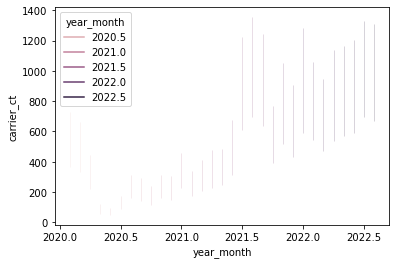

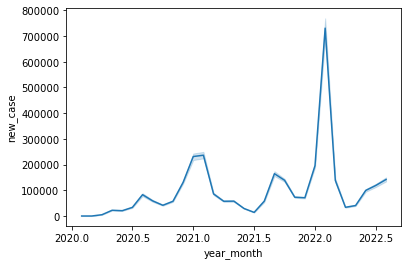

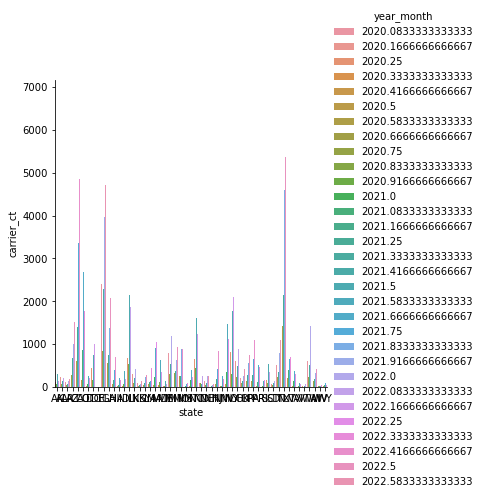

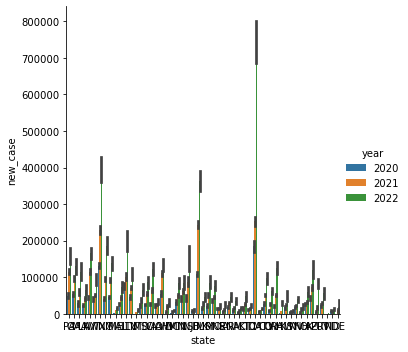

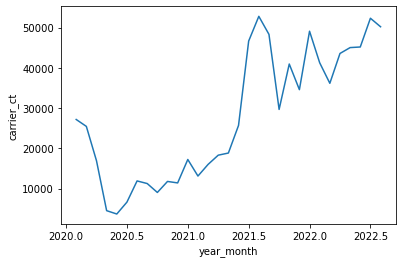

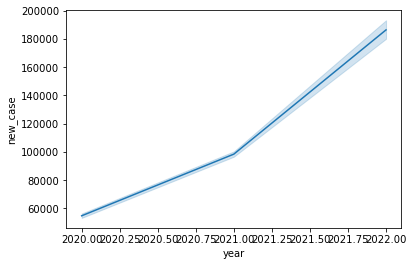

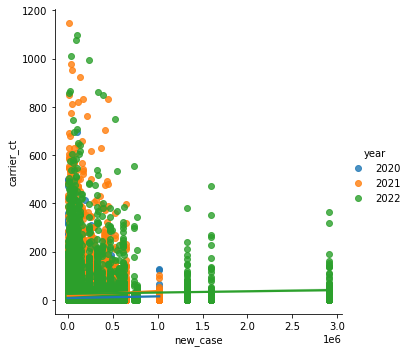

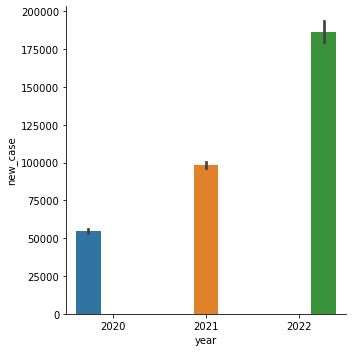

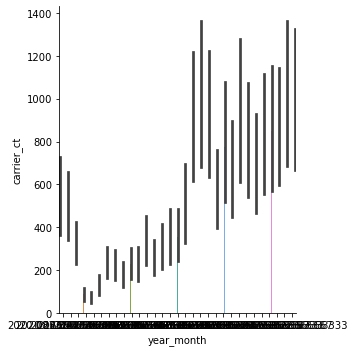

In [62]:
seaborn.lineplot(x='year_month', y='carrier_ct', hue='year_month', data=df_carrier_delay)
plt.show()

seaborn.lineplot(data=df_covid_flight, x='year_month', y='new_case')
plt.show()

seaborn.catplot(x='state', y='carrier_ct', hue='year_month', kind='bar', data=df_carrier_delay)
plt.show()

seaborn.catplot(x='state', y='new_case', hue='year', kind='bar', data=df_covid_flight)
plt.show()

seaborn.lineplot(x='year_month', y='carrier_ct', data=df_carrier_delay_all)
plt.show()

seaborn.lineplot(x='year', y='new_case', data=df_covid_flight)
plt.show()

seaborn.lmplot(x='new_case', y='carrier_ct', hue='year', data=df_covid_flight)
plt.show()

seaborn.catplot(x='year', y='new_case', hue='year', kind='bar', data=df_covid_flight)
plt.show()

seaborn.catplot(x='year_month', y='carrier_ct', hue='year_month', kind='bar', data=df_carrier_delay)
plt.show()

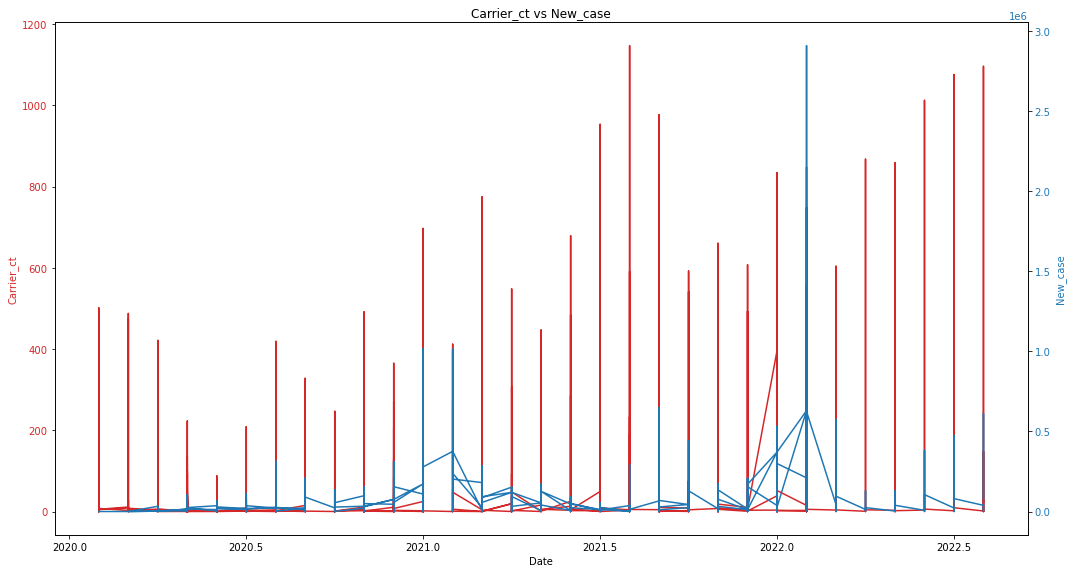

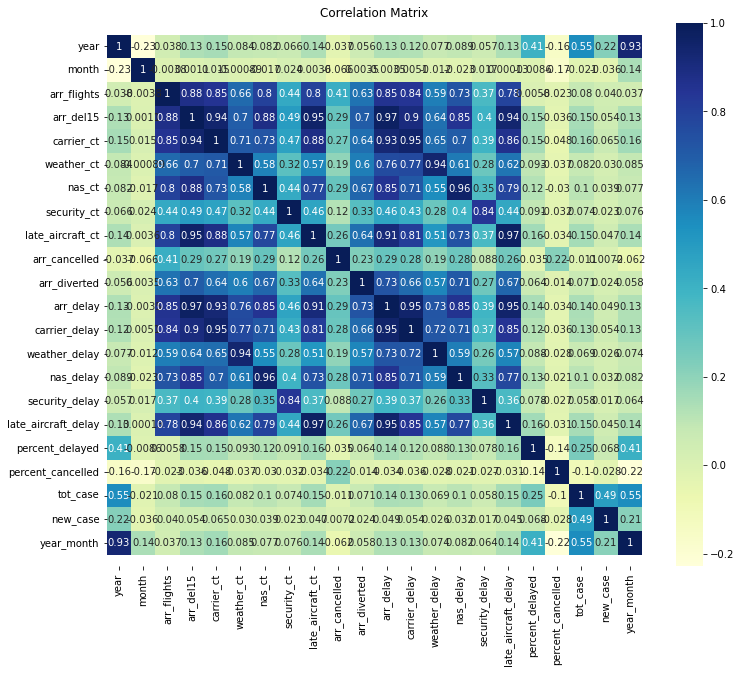

In [67]:
fig, ax1 = plt.subplots(figsize=(15,8))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Carrier_ct', color=color)
ax1.plot(df_covid_flight.year_month, df_covid_flight.carrier_ct, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('New_case', color=color)  # we already handled the x-label with ax1
ax2.plot(df_covid_flight.year_month, df_covid_flight.new_case, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Carrier_ct vs New_case')
plt.show()
 

fig, ax = plt.subplots(figsize=(12,10))  
corr = df_covid_flight.corr()
seaborn.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           cmap="YlGnBu", annot=True, ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation Matrix')
plt.show()

In [71]:
X = df_covid_flight.fillna(0).carrier_ct.values.reshape(-1,1)
y = df_covid_flight.new_case

model = LinearRegression()

model.fit(X, y)

print('R2 score is: ', model.score(X, y))
print('intercept: ', model.intercept_)
print('slope: ', model.coef_)

R2 score is:  0.004219970040140519
intercept:  97671.96418464811
slope:  [302.71322475]


## Questions for reviewers 
1. Should we consider population of a given state when analyzing our data?
2. Should we consider population of a given state when analyzing our data?

 If you think there is some interesting analyses that you could incorporate if you use population data, then yes! Looking at your data right now, I could population data maybe be helpful for a percentage statistic (what percentage of a state population had covid in a given time period. It could also be helpful to scale covid cases using population of state because larger states would most likely have more covid cases. I think including it could add a layer of complexity and yield interesting statistics, but I dont think it is necessary.
 
3. Should we format all graph date axes the same way or is it okay if we specify differences in the header?

It is fine to have different formats as long as the scale you are using makes sense based on the data and it is clear from the title and axis labels what you are plotting. 

4. Are our variable names written in an understandeable manner?
The column names look fine to me, I would note that when you plot them it would be helpful to change the name to something more immediately understandable. For example, in your graph for Delays by Airline at JFK for July 2022, the axis label arr_del15 could be changed to something more informative, but using your current column names for analyses is completely acceptable.

5. Since the COVID dataset contains monthly totals for each state, should we group together airports in the same state for flight delays or evaluate them individually?
I think it might be interesting to do both. I wouldnt only group together airports in the same state, but this could be an interesting additional. One thing that concerns me slightly is that not all the people in an airport would test positive for covid within the state that the airport is located in.
 
6. Are there other relationships for the vars that we should be evaluating?
I think your EDA was pretty encompassing regarding the flight dataset, but I think it would be worth exploring more relationships between the two datasets you have, especially since it concerns your research question. For example, I think it could be interesting to look into arr_delay to see what the relationship is between covid and the actual number of minutes the flight was delayed.

### Preregistration of Analyses ###

1. Comparing how the relationship between the COVID-19 rate and the number of airline delays in the U.S between January 2022-July 2022 varies across different states.
2. Comparing how the relationship between the COVID-19 rate and the number of airline delays in the U.S between January 2022-July 2022 varies across different airlines.

Questions for Reviewers:
1. How should we best account for Covid test reporting differences between states?
2. How should we best account for differences in airline frequencies across different states when comparing the COVID-19 rates and number of airline delays across different airlines?